In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pickle
import os
from scipy.stats import kruskal
from statannotations.Annotator import Annotator

# --- Setup Matplotlib for consistent font rendering ---
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# ==========================================
# 1. Load the Model
# ==========================================
model_path = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Models/daporinad_new_splits/DAPORINAD_NAMPT_forgeModel_rankedHP_321456.pkl"

print(f"Loading model from: {model_path}")
with open(model_path, "rb") as f:
    model = pickle.load(f)

Loading model from: /home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Models/daporinad_new_splits/DAPORINAD_NAMPT_forgeModel_rankedHP_321456.pkl


In [3]:
# ==========================================
# 2. Data Preparation & Alignment
#    (Based on your provided snippet)
# ==========================================

# Load raw data using paths stored in the model object
# Note: Ensure these paths are accessible from your current environment
print("Loading Expression, Dependency, and IC50 data...")
exp_data = pd.read_csv(model.exp_path, header=0, index_col=0)
dep_data = pd.read_csv(model.dep_path, header=0, index_col=0)

# Handling IC50: The model object might have a specific internal structure
# We try to read from path, but based on your snippet, we prioritize the object's attribute format
if hasattr(model, 'ic50_data') and model.ic50_data is not None:
    ic50_data = model.ic50_data.T
else:
    ic50_temp = pd.read_csv(model.ic50_path, header=0, index_col=0)
    ic50_data = ic50_temp.T

# Find common cell lines
common_cellLines = list(set(exp_data.index) & set(dep_data.index) & set(ic50_data.index))
print(f"Common cell lines found: {len(common_cellLines)}")

# Filter data for target gene and drug
# 1. Align indices
exp_data_subset = exp_data.loc[common_cellLines, model.hcg_list].drop_duplicates(keep='first')
dep_target = dep_data.loc[common_cellLines, model.target].dropna().drop_duplicates(keep='first')
drug_ic50 = ic50_data.loc[common_cellLines, model.drug].dropna().drop_duplicates(keep='first')

# 2. Re-align to the dependency index (ensures exact match)
exp_data_subset = exp_data.loc[dep_target.index, model.hcg_list]
drug_ic50 = ic50_data.loc[dep_target.index, model.drug]

# Update model object data (optional, but keeps consistency with your snippet)
model.exp_data = exp_data_subset
model.dep_data = dep_target
model.ic50_data = drug_ic50

print(f"Final Data Shapes -> Exp: {model.exp_data.shape}, Dep: {model.dep_data.shape}, IC50: {model.ic50_data.shape}")

Loading Expression, Dependency, and IC50 data...
Common cell lines found: 700
Final Data Shapes -> Exp: (697, 199), Dep: (697,), IC50: (697,)


In [4]:
# ==========================================
# 3. Train / Test Splitting
# ==========================================
common_train_cellLines = list(set(model.train_cellLines) & set(model.exp_data.index))
common_test_cellLines = list(set(model.test_cellLines) & set(model.exp_data.index))

# Prepare Numpy Arrays
G_train = model.exp_data.loc[common_train_cellLines, :].to_numpy()
G_test  = model.exp_data.loc[common_test_cellLines, :].to_numpy()

D_train = model.dep_data.loc[common_train_cellLines].to_numpy().reshape(-1, 1)
D_test  = model.dep_data.loc[common_test_cellLines].to_numpy().reshape(-1, 1)

I_train = model.ic50_data.loc[common_train_cellLines].to_numpy().reshape(-1, 1)
I_test  = model.ic50_data.loc[common_test_cellLines].to_numpy().reshape(-1, 1)

In [5]:
# ==========================================
# 4. Latent Factor Calculations & Predictions
# ==========================================
# Latent embeddings (Z)
Z_train = G_train @ model.W
Z_test  = G_test  @ model.W

# Predictions
pred_D_train = Z_train @ model.hD
pred_D_test  = Z_test  @ model.hD

pred_I_train = Z_train @ model.hI
pred_I_test  = Z_test  @ model.hI

# Calculate Benefit Score (Predicted Dependency - Predicted IC50)
# Note: Check if the logic requires (Dep - IC50) or (IC50 - Dep) based on biological context.
# Assuming standard logic: High Benefit = High Dependency (Positive) and Low IC50 (Small).
# If Dep is essentiality (negative is bad), logic might differ.
# STICKING TO YOUR PREVIOUS CODE LOGIC:
benefit_train = pred_D_train - pred_I_train
benefit_test  = pred_D_test - pred_I_test

In [6]:
# ==========================================
# 5. Build DataFrame for Plotting (Test Set)
# ==========================================

# Create DataFrame
df_test_plot = pd.DataFrame({
    "IC50": I_test.flatten(),
    f"{model.target} Dependency": D_test.flatten(),
    "Benefit Score": benefit_test.flatten()
})

# Create Quartile Bins
df_test_plot["Benefit Score Bin"] = pd.qcut(
    df_test_plot["Benefit Score"],
    q=4,
    labels=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"]
)

/tmp/ipykernel_840785/2570634692.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("Oranges")
/tmp/ipykernel_840785/2570634692.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


Kruskal-Wallis p-value for IC50: 7.9751e-07


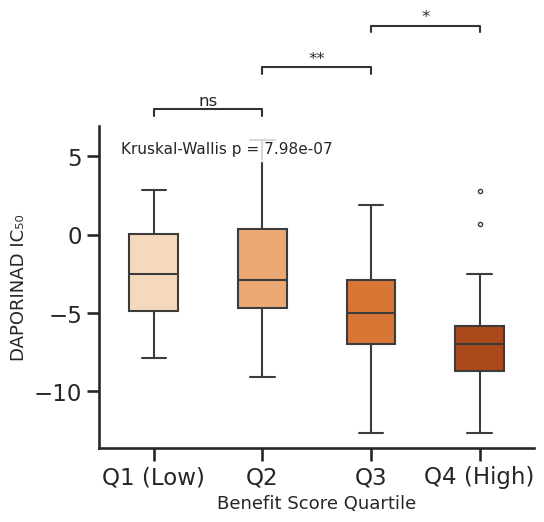

Kruskal-Wallis p-value for Dependency: 9.3079e-02


/tmp/ipykernel_840785/2570634692.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


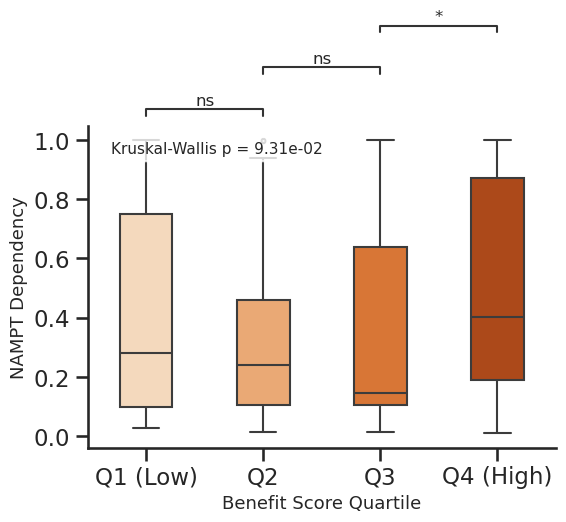

Processing complete. Plots saved.


In [7]:
# ==========================================
# 6. Visualization & Statistics
# ==========================================

# Settings
save_path = "/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/git_repo/Figs/Fig5"
os.makedirs(save_path, exist_ok=True)

sns.set(style="white", context="talk")
cmap = plt.cm.get_cmap("Oranges")
palette = [cmap(i) for i in [0.2, 0.4, 0.6, 0.8]]
box_width = 0.45
pairs = [("Q1 (Low)", "Q2"), ("Q2", "Q3"), ("Q3", "Q4 (High)")]

# --- Plot 1: IC50 Boxplot ---

# Kruskal-Wallis Test
kw_ic50 = kruskal(*[df_test_plot[df_test_plot["Benefit Score Bin"] == q]["IC50"] for q in ["Q1 (Low)", "Q2", "Q3", "Q4 (High)"]])
print(f"Kruskal-Wallis p-value for IC50: {kw_ic50.pvalue:.4e}")

plt.figure(figsize=(6, 6))
ax = sns.boxplot(
    data=df_test_plot,
    x="Benefit Score Bin",
    y="IC50",
    palette=palette,
    width=box_width,
    linewidth=1.5,
    fliersize=3,
    order=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"]
)

# Statistical Annotations
annotator = Annotator(ax, pairs, data=df_test_plot, x="Benefit Score Bin", y="IC50", order=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"])
annotator.configure(test="Mann-Whitney", text_format='star', loc='outside', comparisons_correction=None, verbose=0)
annotator.apply_and_annotate()

# Formatting
for text in ax.texts:
    text.set_fontsize(12)

sns.despine(top=True, right=True)
plt.xlabel("Benefit Score Quartile", fontsize=13)
plt.ylabel(f"{model.drug} IC₅₀", fontsize=13) # Dynamic label
plt.tick_params(axis='both', which='both', bottom=True, left=True)

# Add Kruskal-Wallis p-value
ax.text(0.05, 0.95, f"Kruskal-Wallis p = {kw_ic50.pvalue:.2e}",
        transform=ax.transAxes, fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(save_path, "IC50_boxplot_testset.pdf"))
plt.show()


# --- Plot 2: Dependency Boxplot ---

dep_col_name = f"{model.target} Dependency"

# Kruskal-Wallis Test
kw_dep = kruskal(*[df_test_plot[df_test_plot["Benefit Score Bin"] == q][dep_col_name] for q in ["Q1 (Low)", "Q2", "Q3", "Q4 (High)"]])
print(f"Kruskal-Wallis p-value for Dependency: {kw_dep.pvalue:.4e}")

plt.figure(figsize=(6, 6))
ax = sns.boxplot(
    data=df_test_plot,
    x="Benefit Score Bin",
    y=dep_col_name,
    palette=palette,
    width=box_width,
    linewidth=1.5,
    fliersize=3,
    order=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"]
)

# Statistical Annotations
annotator = Annotator(ax, pairs, data=df_test_plot, x="Benefit Score Bin", y=dep_col_name, order=["Q1 (Low)", "Q2", "Q3", "Q4 (High)"])
annotator.configure(test="Mann-Whitney", text_format='star', loc='outside', comparisons_correction=None, verbose=0)
annotator.apply_and_annotate()

# Formatting
for text in ax.texts:
    text.set_fontsize(12)

sns.despine(top=True, right=True)
plt.xlabel("Benefit Score Quartile", fontsize=13)
plt.ylabel(f"{model.target} Dependency", fontsize=13) # Dynamic label
plt.tick_params(axis='both', which='both', bottom=True, left=True)

# Add Kruskal-Wallis p-value
ax.text(0.05, 0.95, f"Kruskal-Wallis p = {kw_dep.pvalue:.2e}",
        transform=ax.transAxes, fontsize=11,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(save_path, "Dependency_boxplot_testset.pdf"))
plt.show()

print("Processing complete. Plots saved.")